In [1]:
# %pip install nltk
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install matplotlib
# %pip install tensorflow

In [2]:
import re
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, SpatialDropout1D

In [3]:
nltk.download('stopwords')

from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHASHWAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_df = pd.read_excel("../Scrapper_New/Data_Files/Final/CrimevsNonCrime.xlsx")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16864 entries, 0 to 16863
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   16864 non-null  object
 1   Label   16864 non-null  object
dtypes: object(2)
memory usage: 263.6+ KB
None


In [5]:
print(train_df.describe())

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

                                                    Title  Label
count                                               16864  16864
unique                                              16330      2
top     FIFA takes on EA Sports video game in soccer’s...  Crime
freq                                                    4   8641
All entries unique: False
Null cells: 0


In [6]:
train_df.drop_duplicates(subset=['Title'], inplace=True, ignore_index=True, keep='first')

print(f"All entries unique: {train_df['Title'].nunique()==train_df.shape[0]}")
print(f"Null cells: {train_df.isnull().sum().sum()}")

All entries unique: True
Null cells: 0


In [7]:
filtered_df = pd.DataFrame(columns=['text', 'label', 'word_count', 'label_name'])

filtered_df['label_name'] = pd.Series(pd.Categorical(train_df['Label']))
filtered_df['label'] = (pd.Categorical(filtered_df['label_name']).codes).astype(int)
label_ids = dict(enumerate(filtered_df['label_name'].cat.categories))

print("Label IDs")
print(label_ids)

Label IDs
{0: 'Crime', 1: 'Non-Crime'}


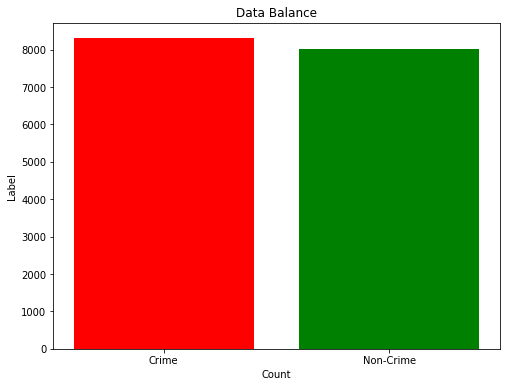

In [8]:
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Data Balance')
plt.show()

In [20]:
def preprocess_x(data, get_word_count = False, single_entry=False):
    text_list = []
    word_count = []

    if not single_entry:
        for entry in data:
            new_text = re.sub("[^a-zA-Z ]", " ", entry)
            new_text = [word for word in new_text.lower().split() if word not in STOPWORDS]
            word_count.append(len(new_text))
            new_text = ' '.join(new_text)
            text_list.append(new_text)
    else:
        new_text = re.sub("[^a-zA-Z ]", " ", data)
        new_text = [word for word in new_text.lower().split() if word not in STOPWORDS]
        word_count.append(len(new_text))
        new_text = ' '.join(new_text)
        text_list.append(new_text)
    
    if get_word_count:
        return text_list, word_count
    else:
        return text_list

In [21]:
filtered_df['text'], filtered_df['word_count'] = preprocess_x(train_df['Title'], get_word_count=True)

print(filtered_df.head())

                                                text  label  word_count  \
0  minor raped cop jharkhand hazaribagh accused a...      0           7   
1  saw brother getting killed bhilwara victim bro...      0          11   
2  delhi police arrests burglar recovers huge qua...      0          11   
3  pregnant woman raped hospital staff mirzapur a...      0           8   
4  muzaffarpur year old girl thrashed gang raped ...      0           9   

  label_name  
0      Crime  
1      Crime  
2      Crime  
3      Crime  
4      Crime  


Average Word count: 8.88658909981629


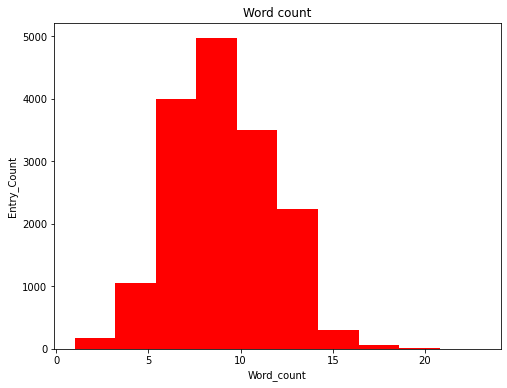

In [22]:
plt.figure(figsize=(8, 6))
print(f'Average Word count: {np.average(filtered_df["word_count"])}')
plt.hist(filtered_df['word_count'],color='red')
plt.title('Word count')
plt.xlabel('Word_count')
plt.ylabel('Entry_Count')
plt.show()

In [23]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
TRUNC_TYPE= 'post'
PADDING_TYPE = 'post'
OOV_TOK= '<OOV>'
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1
LR = 0.001
DECAY = 1e-6
NUM_EPOCH = 5

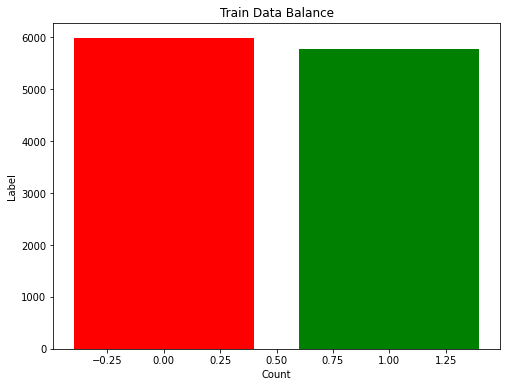

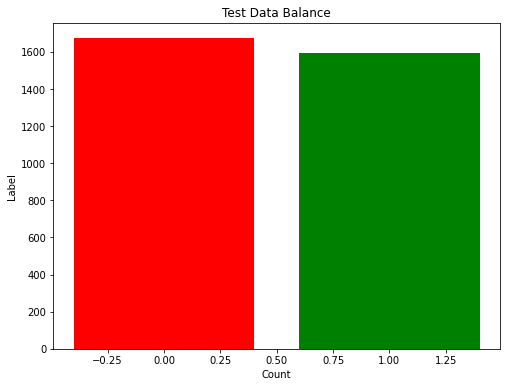

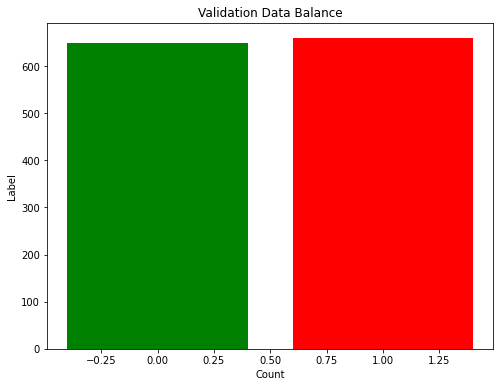

In [24]:
x_train_val,x_test,y_train_val,y_test = train_test_split(filtered_df['text'], filtered_df['label'], test_size=TEST_SIZE,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train_val, y_train_val, test_size=VALIDATION_SIZE,shuffle=True)

train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Train Data Balance')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(test_label_counts.index, test_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Test Data Balance')
plt.show()
plt.figure(figsize=(8, 6))
plt.bar(val_label_counts.index, val_label_counts, color=['red', 'green'])
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Validation Data Balance')
plt.show()

In [25]:
def tokenise(tokenizer, data, maxlen=MAX_SEQUENCE_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE):
    data_sequences = tokenizer.texts_to_sequences(data)
    data_padded = pad_sequences(data_sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    return data_padded

In [26]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(filtered_df['text'])
word_index = tokenizer.word_index

x_train_padded = tokenise(tokenizer, x_train)
x_test_padded = tokenise(tokenizer, x_test)
x_val_padded = tokenise(tokenizer, x_val)

In [30]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         2000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 402       
                                                                 
Total params: 2,161,202
Trainable params: 2,161,202
Non-trainable params: 0
_________________________________________________________________


In [31]:
optimizer = Adam(learning_rate=LR, decay=DECAY)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

history = model.fit(
    x_train_padded, y_train,
    epochs=5,
    # validation_split=0.1,
    validation_data=(x_val_padded, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
    verbose=2)

Epoch 1/5
368/368 - 188s - loss: 0.3520 - accuracy: 0.8386 - val_loss: 0.2655 - val_accuracy: 0.8914 - 188s/epoch - 510ms/step
Epoch 2/5
368/368 - 166s - loss: 0.1429 - accuracy: 0.9465 - val_loss: 0.3320 - val_accuracy: 0.8768 - 166s/epoch - 451ms/step
Epoch 3/5
368/368 - 161s - loss: 0.0615 - accuracy: 0.9783 - val_loss: 0.4998 - val_accuracy: 0.8615 - 161s/epoch - 438ms/step
Epoch 4/5
368/368 - 160s - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.5919 - val_accuracy: 0.8623 - 160s/epoch - 436ms/step


In [32]:
accr = model.evaluate(x_test_padded,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

103/103 [==============================] - 16s 156ms/step - loss: 0.5466 - accuracy: 0.8686
Test set
  Loss: 0.547
  Accuracy: 0.869


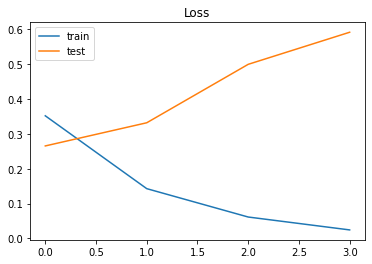

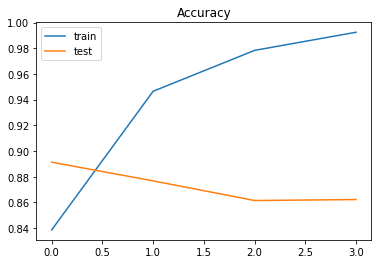

In [33]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [34]:
new_complaint = ["NRC to be carried out across India, Shah tells Rajya Sabha; Mamata says 'won't allow'"]
pre_complaint = preprocess_x(new_complaint)
padded = tokenise(tokenizer, pre_complaint)
pred = model.predict(padded)
print(pred,np.argmax(pred),label_ids[np.argmax(pred)])

[[4.1780935e-04 9.9958223e-01]] 1 Non-Crime
